# Some data analysis on OKCupid dataset
On OKCupid, the users can answer questions where the answers are then used by OKCupid to find good matches for dating. This dataset contains the answers (or lack of) to all questions by many users.

This dataset was scraped by some guy without consent from OKCupid or the users of the site. It contains the usernames which could be incriminating. I have removed the usernames from the dataframe but perhaps it's unethical to use it anyway? Hopefully not if it's not for any commerical reasons.

In [1]:
import os
import textwrap
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

In [2]:
questions = pd.read_csv("data/questions.csv", sep=";", index_col=0)
df = pd.read_csv("data/user_data.csv.bz2", compression="bz2", low_memory=False).drop(["Unnamed: 0", "d_username"], axis=1)

Let's first explore what the columns in this dataset are. They are all matched to rows in the *questions* dataframe that holds the question text, the possible answers, and the category of the question.

In [3]:
from collections import Counter
type_counts = Counter([c[0] for c in df.columns])
types = [("Questions", "q"), ("Personality", "p"), ("About", "d"), ("Looking for", "l")]
pd.DataFrame({type_name: [type_counts[t]] for type_name, t in types})

,About,Looking for,Personality,Questions
0,22,6,50,2541


In [4]:
get_cols = lambda sw: [c for c in df.columns if c.startswith(sw)]
display(df[get_cols("l")].sample(3))
display(df[get_cols("d")].sample(3))
display(df[get_cols("p")].sample(3))

,lf_want,lf_max_age,lf_for,lf_location,lf_min_age,lf_single
15451,Men,26.0,For new friends,Near me,18.0,Who are single
35723,Women,40.0,"For new friends, long-term dating, short-term...",Located anywhere,21.0,Who are single
41034,Women,37.0,For new friends,Near me,25.0,Who are single


,d_astrology_seriosity,d_education_phase,d_gender,d_income,d_religion_type,d_drugs,d_smokes,d_astrology_sign,d_country,d_drinks,...,d_offspring_current,d_bodytype,d_job,d_orientation,d_languages,d_relationship,d_offspring_desires,d_city,d_education_type,d_religion_seriosity
61832,and it's fun to think about,Working on,Man,"$20,000-$30,000",Other,Never,No,Virgo,NY,Socially,...,NaN,Athletic,Sales / Marketing,Straight,English,Single,NaN,Brooklyn,two-year college,but not too serious about it
23574,NaN,Dropped out of,Man,NaN,Atheism,Never,No,-,Netherlands,Socially,...,-,NaN,Technology,Straight,"English (Fluently), Dutch (Fluently), German (...",Single,NaN,Arnhem,space camp,NaN
56874,NaN,Graduated from,Man,"$50,000-$60,000",-,Never,No,Cancer,NC,Socially,...,NaN,Athletic,Management,Straight,English (Fluently),Single,NaN,Raleigh,two-year college,NaN


,p_conf,p_laidback,p_drug,p_lit,p_progress,p_roman,p_dominant,p_polit,p_pure,p_manners,...,p_comp,p_lovedri,p_sprit,p_passion,p_energetic,p_exer,p_logic,p_math,p_geeky,p_adven
50208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21126,65.0,NaN,NaN,44.0,NaN,NaN,NaN,69.0,NaN,NaN,...,NaN,-51.0,-35.0,NaN,NaN,3.0,54.0,21.0,NaN,13.0
45996,NaN,14.0,NaN,12.0,NaN,NaN,NaN,30.0,NaN,NaN,...,69.0,NaN,NaN,NaN,NaN,34.0,NaN,5.0,NaN,88.0


## Correlations
We can start by looking at some contingency tables between different questions to see the distribution over answers to them. I chose random questions initially to find some interesting pairs.

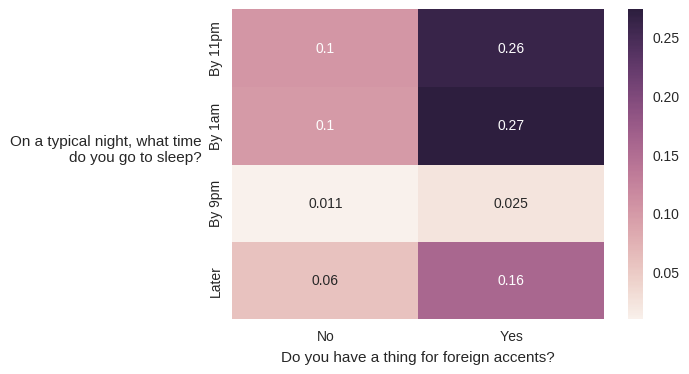

In [5]:
def contingency_table(col1, col2, normalize=True):
    axes = sns.heatmap(pd.crosstab(col1, col2, normalize=normalize), annot=True)
    q1 = questions.text[col1.name]
    q2 = questions.text[col2.name]
    tw = lambda t, w: "\n".join(textwrap.wrap(t, w))
    axes.set_ylabel(tw(q1, 30), rotation=0, ha="right")
    axes.set_xlabel(tw(q2, 60))

randq = lambda: df.sample(1, axis=1).squeeze()
contingency_table(randq(), randq())

Just sampling these randomly doesn't really give much though. Maybe if we look at a specific personality trait combined with some question it will give a more interesting contingency table. 

TODO personality values are numerical, use correlation instead

In [99]:
#contingency_table(df.p_introvert, df.p_extro)

## Clustering
It would be interesting to find groups of users that have answered many questions similarly. OkCupid likely does something like it behind the scenes for their matching algorithm. Since we have categorical data (each question/column can have one of some preset answers only) using something like *KMeans* wouldn't work so great since euclidean distance doesn't mean anything in this feature space. Instead we can try a similar algorithm called *KModes* which should work better in this setting because instead of distances it used dissimilarities basically, i.e. if two data rows have answered many questions similarly they should be close together and if they have answered many questions different they should be further apart. $D(x_i, x_j) = \sum_N I(x_{i,n} = x_{j, n})$

Since we have quite a few features, I was not able to use that many rows of data to fit the KModes predictor which could mean we get bad segmentation. I assume parts of the algorithm could be parallelized, like computing the dissimilarity of each point to all centroids in every update iteration which might speed things up a bit. The library implementation doesn't do this though.

TODO: equations
TODO: citations

In [6]:
# Prepare dataframe to work with KModes library by substituting question answers to numerical values. 
# Also skipping some columns that have too many categories, like cities and country. 
# The limit is arbitrarily chosen.
df_kmodes = pd.DataFrame()
for c in df.columns:
    cat_col = df[c].astype("category").cat
    if len(cat_col.categories) < 15:
        #df_kmodes = pd.concat([df_kmodes, cat_col.codes.apply(lambda i: i if i != -1 else None)], axis=1)
        df_kmodes = pd.concat([df_kmodes, cat_col.codes], axis=1)

In [7]:
# Fit KModes
from kmodes import kmodes
km = kmodes.KModes(n_clusters=10)
X_subset = df_kmodes.sample(1000)
clusters = km.fit_predict(X_subset, verbose=1)

# TODO: maybe should use k prototypes instead, seems like there is some numerical data as well for some cols
# TODO: what about missing values? Should they be treated differently? are they distorting the result?
# TODO: maybe we should set -1 (pandas NaN) to np.NaN
# TODO: Seems like the kmodes lib sets all nans to -1, but that seems like a bad solution imo
# TODO: paralllized parts of kmodes algo to handle larger dataset

In [8]:
# Assign a cluster index to each user response
assigned_clusters = km.predict(df_kmodes)

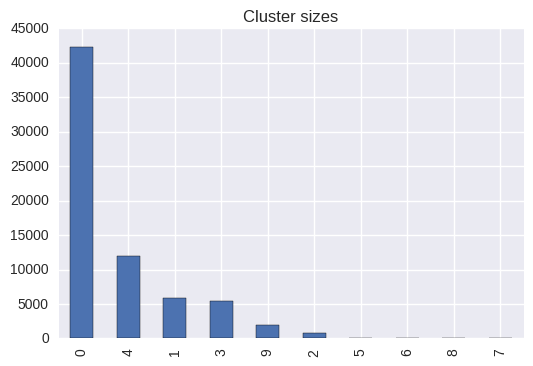

In [60]:
pd.Series(assigned_clusters).value_counts().plot("bar", title="Cluster sizes")

This looks pretty boring. Many clusters are not even used which indicates that TODO

We might want to look at how questions are answered differently in different clusters

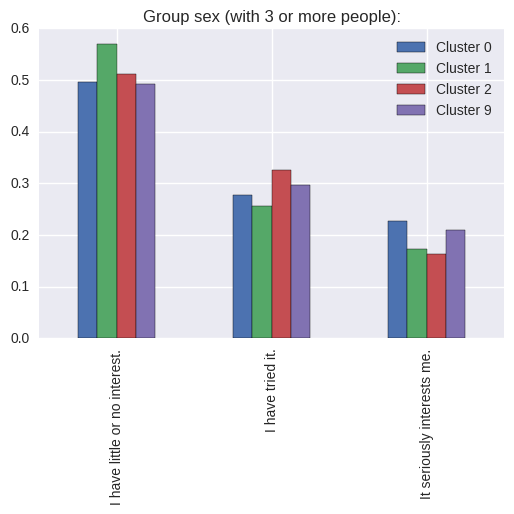

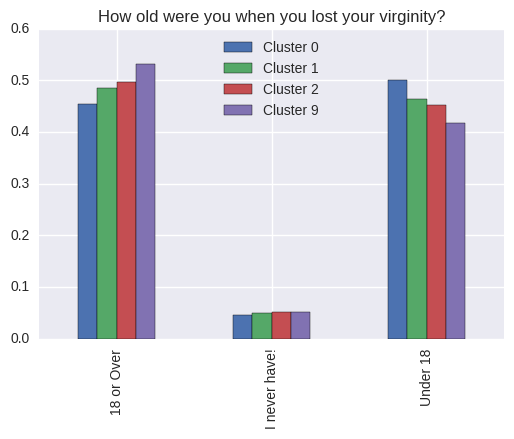

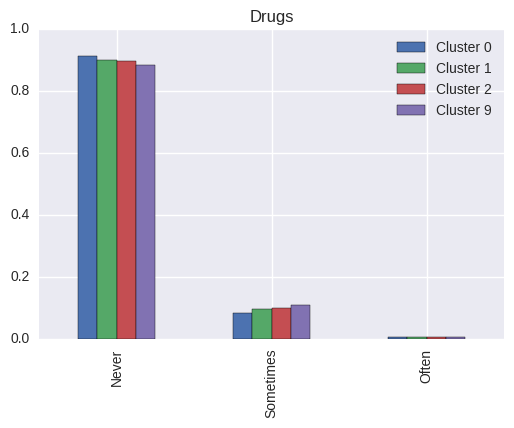

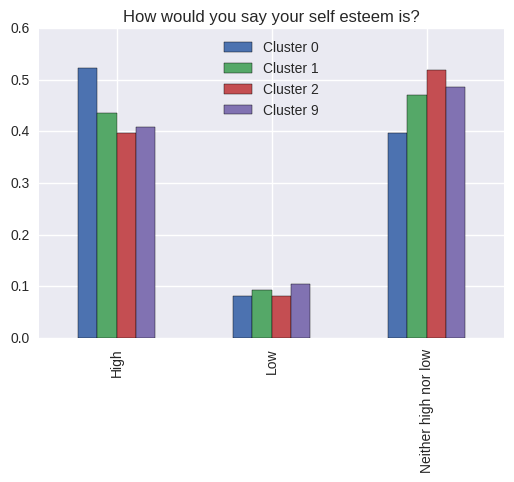

In [100]:
def compare_answer_distributions(question_id, cluster_ids, dropna=True):   
    def count_cluster_answers(cluster_id):
        idxs = np.where(assigned_clusters == cluster_id)
        cluster_answer_counts = df[question_id].loc[idxs].value_counts(normalize=True, dropna=dropna)
        cluster_answer_counts.rename("Cluster {}".format(cluster_id), inplace=True)
        return cluster_answer_counts
    
    answer_counts = pd.concat([count_cluster_answers(cluster_id) for cluster_id in cluster_ids], axis=1)
    answer_counts.plot.bar(title=questions.loc[question_id].text)
    
compare_answer_distributions(question_id="q32", cluster_ids=[0, 1, 2, 9])
#compare_answer_distributions(question_id="q32", cluster_ids=[0, 1, 2], dropna=False)
compare_answer_distributions(question_id="q37", cluster_ids=[0, 1, 2, 9])
compare_answer_distributions(question_id="d_drugs", cluster_ids=[0, 1, 2, 9])
compare_answer_distributions(question_id="q19691", cluster_ids=[0, 1, 2, 9])

TODO: contingency table of questions with personality types